# Initalization

In [1]:
# Import modules and set the calibration image path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

%matplotlib inline


cal_img_dir = "./camera_cal"
cal_img_fname_general = os.path.join(cal_img_dir,"calibration{}.jpg")

Load a Sample image

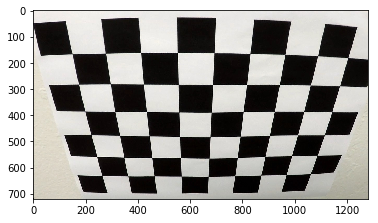

In [2]:
img_path = cal_img_fname_general.format(2)
img = plt.imread(img_path)
plt.imshow(img)

# Undistort an image

<img src="img_ref/objpoints_description.png" style="width:760px;height:402;"> <br>

Obeject points are coordinates of the chessboard points in the real world. The z-coordinate will stay 0 and x and y coordinates are as shown in the image above. The image above is misleading because in out case, there should be 6 
rows and 8 columns. The image only has 5 rows and 7 columns. (The outter corners are not counted towards the number of corners)

In [3]:
def findChessboardCorners_wrapper(img,nxny=(9,6)):
    nx,ny = nxny
    # --- convert the image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # --- Find the chessboard corners
    # ret is simply a boolean return value that is true if the corners are found and false if otherwise
    foundCorners, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If the input (nx,ny) are not true, iterate to find nx,ny
    # inclusive range
    nx_range=(6,9)
    ny_range=(4,6)
    nx_it = nx_range[0]
    ny_t = ny_range[0]
    while not foundCorners and nx_it <= nx_range[-1]:
        foundCorners, corners = cv2.findChessboardCorners(gray, (nx_it,ny_it), None)
        
        if not foundCorners:
            ny_it += 1
            if ny_it > ny_range[1]:
                ny_it = ny_range[0]
                nx_it += 1
        else:
            nx = nx_it
            ny = ny_it
    
    
    if foundCorners:
        # --- Prepare object points, (0,0,0), (1,0,0), (2,0,0), ... , (7,5,0)
        # initialize nx X ny of 3-tuples (x,y,z) with all zeros 
        objp = np.zeros((nx*ny,3),np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
        cornerDim = (nx,ny)
        return corners, objp, cornerDim
    
    else:
        return None,None,None

I noticed the number of corners in each image differs by a little depending on how to image was cropped. Therefore, I will start with an initial guess value of nx = 7 and ny = 4 and do a grid search to nx_max = 9 and ny_max = 6. For some reason, the chessboard corners for the "calibration4.jpg" could not be found. I discarded the image.

In [180]:
import glob
# Read in and make a list of calibration image paths
img_paths = glob.glob(cal_img_fname_general.format("*"))

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in imagNe plane
img_list = [] 
cornerDim = [(9, 5),(9, 6),(9, 6),(9, 6),(9, 6),(8, 6),(9, 6),(9, 6),(9, 6),(9, 6),
             (9, 6),(7, 4),(9, 6),(9, 6),(7, 6),(9, 6),(9, 6),(9, 6),(9, 6)] # array of (nx,ny) tuples

nxny_list = []

# img_path = "./camera_cal/calibration4.jpg"
# img = plt.imread(img_path)
# plt.imshow(img)
# corners, objp, nxny_ret = findChessboardCorners_wrapper(img,(9,6))
# print(nxny_ret)
for img_path,nxny in zip(img_paths,cornerDim):

    img = plt.imread(img_path)
    
    corners, objp, nxny_ret = findChessboardCorners_wrapper(img,nxny)
    img_list.append(img)
    objpoints.append(objp)
    imgpoints.append(corners)
    nxny_list.append(nxny_ret)



### Example Images with cv2.drawChessboardCorners

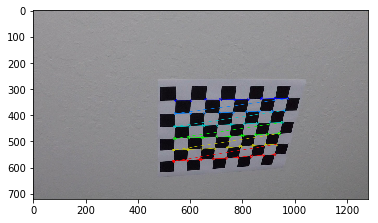

In [181]:
example_index = 1
img_chessBoard = np.copy(img_list[example_index])
cv2.drawChessboardCorners(img_chessBoard, nxny_list[example_index], imgpoints[example_index],True)


plt.imshow(img_chessBoard)

# Calibration

In [182]:
def calibrate_wrapper(objpoint,imgpoint,img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    if ret:
        return mtx,dist
    else:
        return None,None
    

In [183]:
ii =0 
mtx_list = []
dist_list = []
for objpoint,imgpoint,img in zip(objpoints,imgpoints,img_list):
    mtx,dist = calibrate_wrapper(objpoint,imgpoint,img)
    
    mtx_list.append(mtx)
    dist_list.append(dist)

### Find the Mean of the Camera Matrix (mtx) and the Distortion Coefficient (dist)
The camera matrix and distortion coefficient should be very similar for all the images

In [184]:
mtx_ave = np.mean(mtx_list,axis=0)
dist_ave = np.mean(dist_list,axis=0)

#### Undistort few of the original images

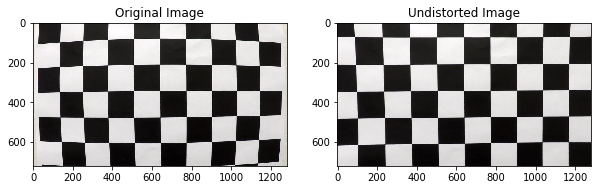

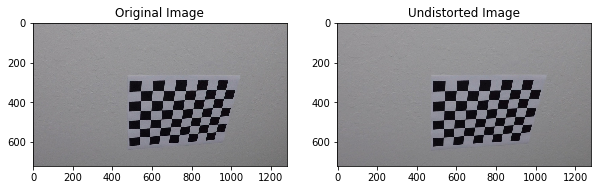

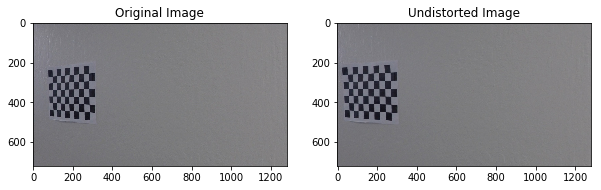

In [185]:
img_list_shuffle = np.copy(img_list) # make a deep copy
# np.random.shuffle(img_list_shuffle) # shuffle the images
# Plot first four of the original and their undistorted images

for img in img_list_shuffle[:3]:
    img_undistort = cv2.undistort(img,mtx_ave,dist_ave,None,mtx_ave)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image")
    
    plt.subplot(1,2,2)
    plt.imshow(img_undistort)
    plt.title("Undistorted Image")


# Undistort and Trasform

Get helper functions to generate the src and dst points.

In [190]:
def getDstFromSrcCorners(img,border=0.05):
    # border : percent of boder. 0 <= border < 0.5
    # src should be the corner coordinates starting from top left corner going clockwise
    # src:
    #    (x0,y0) ----- (x1,y1)
    #       |             |
    #       |             |
    #    (x3,y3) ----- (x2,y2)
    #
    # dst:
    #    (x0,y0) ----- (x1,y0)
    #       |             |
    #       |             |
    #    (x0,y3) ----- (x1,y3)
    # 
    ydim,xdim,_ = img.shape
    dst = []
    dst.append([xdim*border,ydim*border])
    dst.append([xdim*(1-border),ydim*border])
    dst.append([xdim*(1-border),ydim*(1-border)])
    dst.append([xdim*border,ydim*(1-border)])
    
    return np.array(dst,dtype = "float32")  

def findCornerIndex(objpoints,query):
    return np.argmax(np.sum(objpoints==query,axis=1))

def getSrcFromObjPointsAndImgPoints(objpoints,imgpoints):
    # (0,0,0) --- (1,0,0) --- (2,0,0) -...- (nx,0,0)
    # (0,1,0) --- (1,1,0) --- (2,1,0) -...- (nx,1,0)
    # ...
    # (0,ny,0) --- (1,ny,0) --- (2,ny,0) -...- (nx,ny,0)
    nx = np.max(objpoints[:,0])
    ny = np.max(objpoints[:,1])

    ii0 = findCornerIndex(objpoints,[0,0,0])
    ii1 = findCornerIndex(objpoints,[nx,0,0])
    ii2 = findCornerIndex(objpoints,[nx,ny,0])
    ii3 = findCornerIndex(objpoints,[0,ny,0])
    
    return np.array([imgpoints[ii0][0],imgpoints[ii1][0],imgpoints[ii2][0],imgpoints[ii3][0]],dtype = "float32")

def warp(img_undistort,src,dst):
    img_size = img_undistort.shape[:2][::-1]
    img_warped = np.copy(img_undistort)
    
    M = cv2.getPerspectiveTransform(src, dst)
    img_warped = cv2.warpPerspective(img_warped, M, img_size, flags=cv2.INTER_LINEAR)
    return img_warped
    
    
    

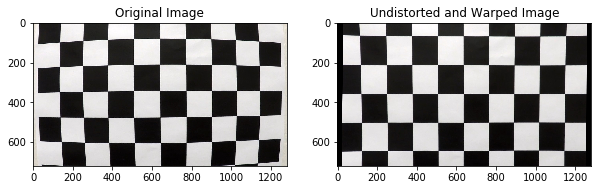

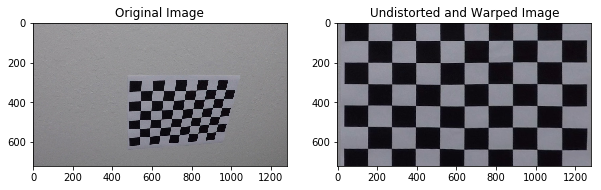

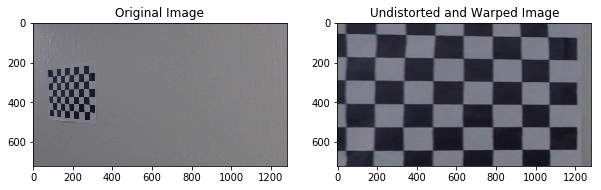

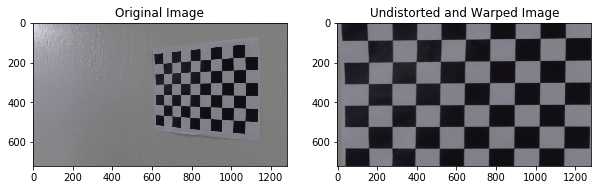

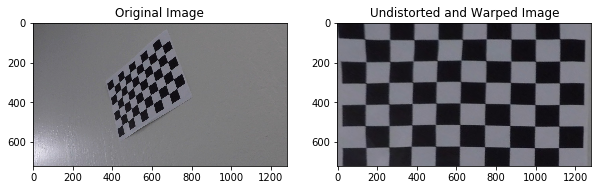

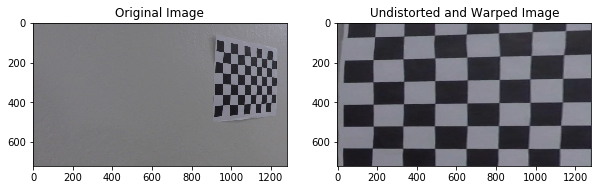

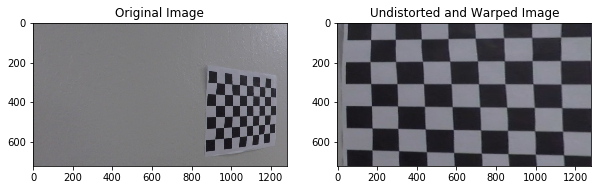

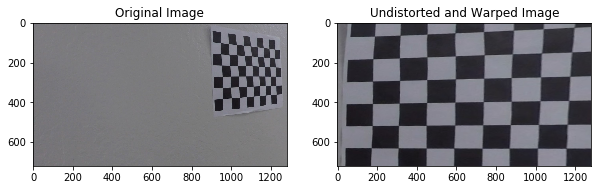

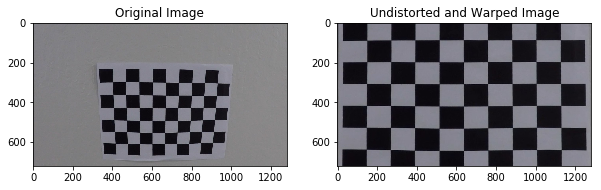

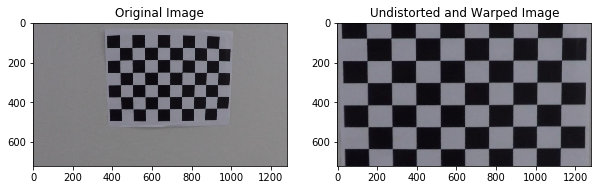

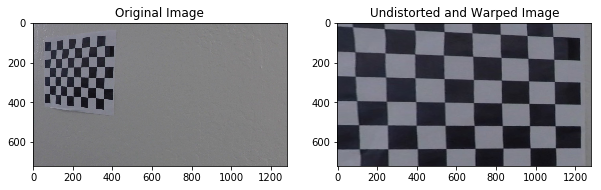

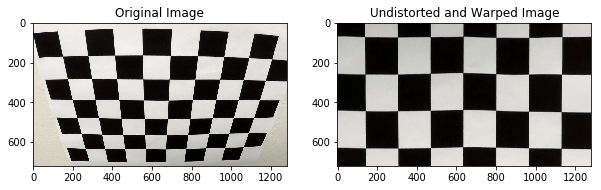

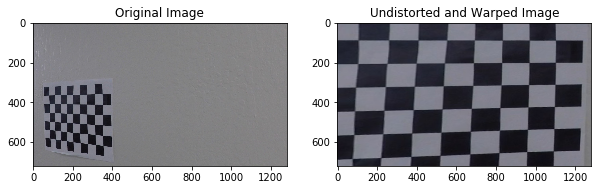

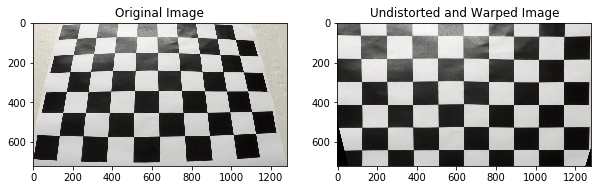

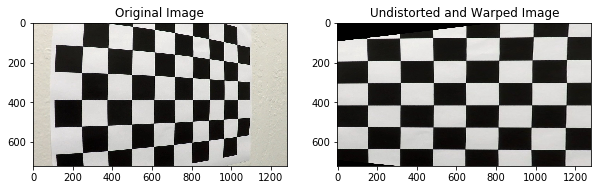

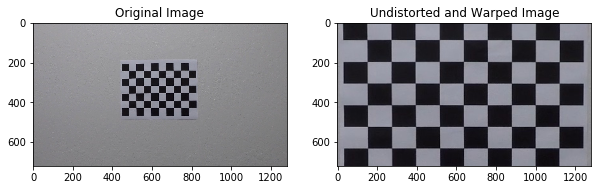

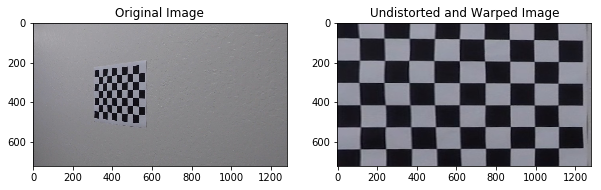

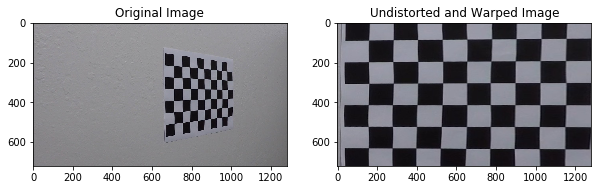

In [193]:
n_examples = -1
for img,objpts,imgpts in zip(img_list[:n_examples],objpoints[:n_examples],imgpoints[:n_examples]):

    src = getSrcFromObjPointsAndImgPoints(objpts,imgpts)
    dst = getDstFromSrcCorners(img,border=0.125)

    img_undistort = cv2.undistort(img,mtx_ave,dist_ave,None,mtx_ave)
    img_warped = warp(img_undistort,src,dst)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image")
    
    plt.subplot(1,2,2)
    plt.imshow(img_warped)
    plt.title("Undistorted and Warped Image")

    
    



